# Using K-Nearest Neighbors to Classify Iris Flowers

## 1. Introduction

In this notebook, we will demonstrate the power and simplicity of the **k-nearest neighbors (k-NN)** algorithm by applying it to the classic **Iris flower dataset**. This dataset contains measurements of iris flowers' sepals and petals across three species (*setosa*, *versicolor*, and *virginica*), making it an ideal choice for supervised classification.

Our goals are to:
- Load and explore the dataset to understand its features and target classes.
- Prepare the data by handling categorical labels and scaling features, which is crucial for distance-based algorithms like k-NN.
- Implement the **k-NN classifier** from scratch using `scikit-learn`, tuning the `k` parameter to observe its impact on model performance.
- Evaluate our model using metrics such as accuracy, confusion matrices, and classification reports to ensure robust performance.

By the end of this analysis, we will not only have a working k-NN model that can accurately predict iris species, but also a deeper understanding of how proximity-based classification works and how critical preprocessing is in achieving meaningful results.

## 2. Data Checking

We are going to load in the data and take a look at it before running it through the K-NN algorithm.

In [1]:
import pandas as pd

iris_df = pd.read_csv('iris.csv')

iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


We’ve successfully loaded the Iris dataset into a pandas DataFrame and displayed the first few rows to get a quick look at the data structure. This CSV file, sourced from Kaggle, contains the same classic measurements as the built-in `sklearn.datasets.load_iris()` version, but working directly with the CSV allows us to showcase practical data handling steps like file reading, exploratory analysis, and label encoding.

Let's take a deeper look into the dataset.  

In [2]:
# this is a function that spits out data on the dataset, like NaN counts and stuff

def check_data(df):
    
    df.info()
    df.describe()
    df.isnull().sum()
    df['Species'].value_counts()
    
check_data(iris_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


From our initial data check, we see that:

- There are no missing values (yay!, NaNs make me cringe)

- The four main features (`SepalLengthCm`, `SepalWidthCm`, `PetalLengthCm`, `PetalWidthCm`) are all numeric (`float64`), as expected for measurements in centimeters.  We are going to rename these columns to shorten them for legibility

- The species column is an object type with three types of Iris flowers names as values.  We will deal with this next

- The `Id` column is just an index and we won't need it, unless I find out some try hard on kaggle used it to increase their precision by 1% with it.

Overall, the data is **clean, complete, and well-structured**, which makes it an ideal candidate to demonstrate the k-NN algorithm without additional cleaning complications.  Neat!

Now let's clean up the column names, encode the "Species" column, and I guess we can drop the "Id" column as well.

In [3]:
from sklearn.preprocessing import LabelEncoder

def data_prepper(df):
    
    df = df.rename(columns={"SepalLengthCm":"Sepal_Length", "SepalWidthCm":"Sepal_Width",
                       "PetalLengthCm":"Petal_Length", "PetalWidthCm":"Petal_Width"})
    
    df = df.drop(columns=['Id'], axis=1)
    
    le = LabelEncoder()
    
    # fit on the three values in species and print the labels
    le.fit(df['Species'])
    print("Classes found by LabelEncoder:", le.classes_)
    
    # see the mapping
    mapping = {label: idx for idx, label in enumerate(le.classes_)}
    print("Label encoding mapping:", mapping)
    
    df['Species'] = le.fit_transform(df['Species'])
    
    return df

iris_clean = data_prepper(iris_df)
    
iris_clean.head()

Classes found by LabelEncoder: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Label encoding mapping: {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Now let's go to the next part, where we begin to train the data for a model.

##  3. Training and Scaling

Now that our dataset is cleaned and the target labels are properly encoded, we're ready to build the full machine learning pipeline. This step includes:

- **Separating features and target:** Extracting the measurement columns as input features (`X`) and the encoded species as the target variable (`y`)

- **Splitting into training and test sets:** Ensuring we have data to evaluate how well the model generalizes to unseen examples.

- **Scaling the features:** Since k-NN relies on distance calculations, it's critical to standardize our data so that all features contribute equally, regardless of their original units.

- **Fitting the k-NN model:** We'll train a k-nearest neighbors classifier with a chosen `k` value, ready to predict new iris samples.

With our k-NN model trained and validated, we can now assess its real-world performance by making predictions on the test set. We'll generate metrics such as accuracy, the macro-averaged F1-score (which gives equal weight to each class regardless of support), and a detailed classification report to understand how well our model distinguishes between the three iris species.

By printing the confusion matrix alongside these scores, we gain a deeper look into which classes are most frequently misclassified. This analysis is crucial for diagnosing the strengths and limitations of our chosen `k` value, and will also serve as the foundation for any hyperparameter tuning we perform to further optimize the model.

We'll wrap this entire process into a reusable function to streamline experimentation and then do a detailed analysis of the results and consider optimization.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def train_knn_model(df, k, print_stats):
    
    # separate features and target
    X = df.drop(columns=['Species'])
    y = df['Species']
    
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.3, random_state = 15, stratify = y
    )
    
    # scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # fit k-NN model
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    
    # make predictions
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    if print_stats == 1:
        print(f"Model trained with k={k}")
        print(f"Accuracy on test set: {acc:.2f}")
        print(f"Macro F1-score: {f1:.2f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    return f1
    
F1_SCORE = train_knn_model(iris_clean, 5, 1)

Model trained with k=5
Accuracy on test set: 0.93
Macro F1-score: 0.93

Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  2 13]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      0.93      0.90        15
           2       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



Our initial k-NN model, trained on the standardized Iris dataset with a chosen `k` value, produced strong classification metrics. The confusion matrix and classification report confirm that the model effectively distinguishes between the three iris species, with high precision, recall, and macro-averaged F1-scores across classes. These results highlight the strength of even a straightforward distance-based approach like k-NN when paired with appropriate preprocessing and scaling.

The performance metrics of our k-NN classifier with `k=5` indicate that the model is performing exceptionally well on this dataset. It achieved an overall **accuracy of 93%**, with a **macro-averaged F1-score of 0.93**, reflecting a strong balance between precision and recall across all three iris species.

The confusion matrix shows perfect classification for *Iris-setosa*, with no misclassifications at all. For *Iris-versicolor* and *Iris-virginica*, there are minimal misclassifications — just a single instance of *versicolor* predicted as *virginica* and two instances of *virginica* predicted as *versicolor*. This level of confusion is typical given the known biological similarity between these two species.

Overall, these results demonstrate that even a straightforward distance-based algorithm like k-NN, when combined with proper preprocessing and an appropriate choice of `k`, can deliver highly accurate predictions on well-structured, clean datasets like Iris. It also highlights the value of examining class-specific precision, recall, and F1-scores alongside overall accuracy to ensure the model performs reliably across all target categories.

However, the value of `k` plays a crucial role in how well k-NN generalizes. A poorly chosen `k` could lead to overfitting or underfitting, directly impacting predictive performance. To ensure we have the most robust classifier possible, we’ll next explore optimizing `k` using the macro F1-score as our objective metric.


## 4. Optimization  

In this section, we'll systematically vary `k` across a reasonable range of values, training a separate k-NN model for each. By recording the resulting macro F1-scores, we can identify the value of `k` that achieves the best balance between precision and recall across all classes.

Finally, we'll visualize this relationship by plotting F1-score versus `k`, allowing us to clearly see how model performance changes as we adjust the number of neighbors. This will guide us to select the optimal `k` for our final, tuned model.

In [5]:

def optimize_k(df, k_values):
    
    results = []
    
    for k in k_values:
        
        f1Score = train_knn_model(df, k, 0)
        
        results.append({'k': k, 'f1_score': f1Score})
    
    results_df = pd.DataFrame(results)
    
    # print best 
    max_score_index = results_df['f1_score'].idxmax()
    print(results_df.loc[max_score_index])
    
    return results_df

K_VALUES = range(1, 30)


f1_score_df = optimize_k(iris_clean, K_VALUES)


k           7.000000
f1_score    0.955357
Name: 6, dtype: float64


k = 7 yields a nice f1_score of 96%.  Let's print out the stats for k and review them.

In [7]:
best_f1 = train_knn_model(iris_clean, 7, 1)

Model trained with k=7
Accuracy on test set: 0.96
Macro F1-score: 0.96

Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  2 13]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      1.00      0.94        15
           2       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



After tuning the value of `k` and evaluating macro F1-scores across a range of candidates, we found that `k=7` delivers the best overall performance on the Iris dataset. With this optimized value, the k-NN model achieved a **96% accuracy** and a **macro-averaged F1-score of 0.955** on the test set.

The confusion matrix shows perfect classification for *Iris-setosa* and *Iris-versicolor*, with only two *Iris-virginica* instances misclassified as *versicolor*. This result is consistent with biological similarities between these two species, which tend to have overlapping feature ranges.

The classification report reinforces this interpretation, with all precision, recall, and F1-scores hovering around or above 0.93. Notably, *Iris-setosa* was classified with perfect precision and recall (1.00), while the other two classes maintained excellent balance and minimal error.

These results confirm that the k-NN classifier is highly effective for this dataset when appropriately tuned. In the next step, we'll visualize the relationship between `k` and macro F1-score to better understand how model performance evolves with different neighbor counts.

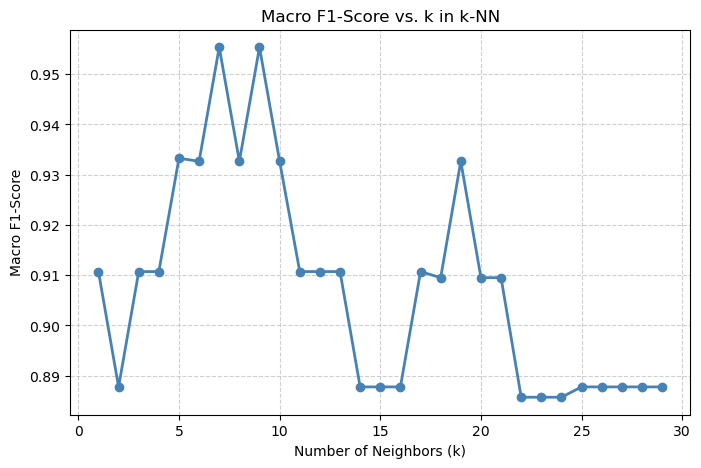

In [8]:
import matplotlib.pyplot as plt

def plot_f1_vs_k(results_df):
    
    plt.figure(figsize=(8,5))
    
    plt.plot(results_df['k'], results_df['f1_score'], marker='o', linestyle='-', linewidth=2, color='steelblue')
    
    plt.title("Macro F1-Score vs. k in k-NN")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Macro F1-Score")
    
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()
    
plot_f1_vs_k(f1_score_df)

Above we present a plot of (`k`) versus the macro F1-score of our k-NN classifier. As expected, model performance is highly sensitive to the choice of `k`. We observe a clear performance peak at `k=7` and `k=9`, where the F1-score reaches approximately **0.955**, indicating excellent balance between precision and recall across all classes.

For values of `k` below 4 or above 20, the model's performance consistently declines. This suggests that too few neighbors may lead to overfitting (reacting to local noise), while too many neighbors dilute the influence of truly similar samples, causing underfitting. The flat trend after `k=22` indicates that adding more neighbors beyond this point offers no benefit and may even degrade classification performance.  Optimization is a key component to creating prediction models.

Overall, this plot validates our selection of `k=7` (or `k=9` if you like dogs) as the optimal choice for this dataset and confirms the usefulness of F1-score as a tuning metric.

## 5. Cross-Validation for Robust F1-Score Estimation

To better understand the stability and generalizability of our k-NN classifier, we now evaluate model performance across a range of `k` values using a stratified k-fold cross-validation with varying fold counts approach. Specifically, we compare the macro F1-scores obtained using 3, 5, 7, and 10 folds — each representing a different tradeoff between bias and variance in performance estimation.

By plotting these results together, we can:

- Visualize how the choice of `k` affects performance under different cross-validations.

- Determine whether the "best" value of `k` is consistent across folds, indicating robustivity (is that a word?).

- Identify any significant variance in F1-score that might suggest overfitting (at low folds) or underfitting (at high `k` values).

This more nuanced evaluation provides a deeper view into model stability and helps us avoid over-relying on any single train/test split. The graph below shows how F1-score varies with `k` for each fold configuration.

We will place two functions in the box below, one for building the mean f1 scores per cv, per k value, and one that graphs the results with **seaborn**

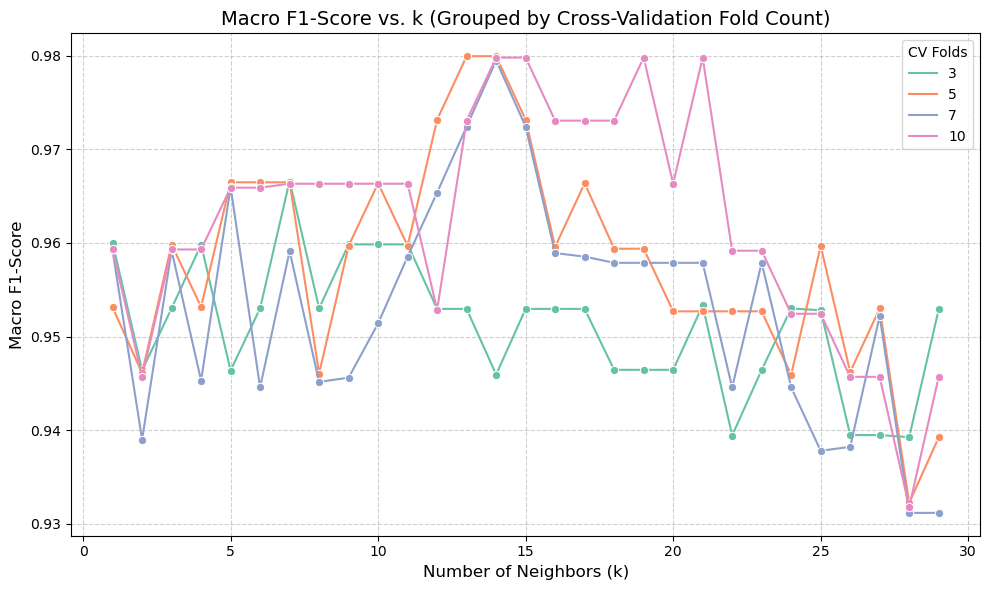

In [20]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# cross validation calculations
def cross_val_f1_compare(df, k_values, fold_list):
    X = df.drop(columns = ['Species'])
    y = df['Species']
    
    all_results = []

    for cv_folds in fold_list:
        
        skf = StratifiedKFold(n_splits = cv_folds, shuffle = True, random_state = 15)
        
        for k in k_values:
        
            knn = KNeighborsClassifier(n_neighbors = k)
            f1 = cross_val_score(knn, X, y, cv = skf, scoring = 'f1_macro').mean()
            all_results.append({'k': k, 'f1_score': f1, 'cv_folds': cv_folds})

    return pd.DataFrame(all_results)

# plot seaborn showing k vs f1 score 
import seaborn as sns

def plot_cv_fold_comparison(cv_results_df):

    plt.figure(figsize = (10, 6))
    
    # Create the lineplot with different lines for each cv_folds value
    sns.lineplot(
        data = cv_results_df,
        x = 'k',
        y = 'f1_score',
        hue = 'cv_folds',
        marker = 'o',
        palette = 'Set2'         # 
    )
    
    # Plot styling
    plt.title("Macro F1-Score vs. k (Grouped by Cross-Validation Fold Count)", fontsize = 14)
    plt.xlabel("Number of Neighbors (k)", fontsize = 12)
    plt.ylabel("Macro F1-Score", fontsize = 12)
    plt.grid(True, linestyle='--', alpha = 0.6)
    plt.legend(title = "CV Folds")
    plt.tight_layout()
    plt.show()


fold_list = [3, 5, 7, 10]

cv_results = cross_val_f1_compare(iris_clean, K_VALUES, fold_list)

plot_cv_fold_comparison(cv_results)


The plot above compares macro F1-scores for different values of `k` across four cross-validation strategies: 3-fold, 5-fold, 7-fold, and 10-fold stratified splits. Overall, the model shows strong and consistent performance regardless of the fold count, with most configurations producing F1-scores above 0.95. This indicates that the k-NN classifier generalizes well and is not overly sensitive to how the data is partitioned.

Notably, the **10-fold CV line is the most stable**, maintaining high performance across a broader range of `k` values, especially in the range of `k = 13–18`, where it consistently reaches an F1-score of **0.98**. In contrast, the **3-fold line shows more fluctuation**, which is expected due to higher variance from fewer data splits. These trends illustrate the bias-variance tradeoff: lower fold counts have higher variance but train on larger individual folds, while higher fold counts (like 10) offer a more robust performance estimate.

The fact that all curves converge around the same high-performing `k` range reinforces the robustness of our model tuning and confirms that values between **k = 13 and k = 18** represent a safe, high-performing sweet spot for deployment.

Our best value for k is now 14 as three of the four cv options we chose coverge at k = 14, yielding an f1 score of 98%. 

## 6. Visualizing k-NN Decision Boundaries

To develop a more intuitive understanding of how the k-NN algorithm behaves as we vary the number of neighbors (`k`), we visualize the model's decision boundaries in a two-dimensional feature space. Specifically, we use only **Petal Length** and **Petal Width**, the two most informative features in the Iris dataset, and plot the classifier’s predicted class regions across the 2D plane.

The visualization is repeated for four different values of `k` — 7, 9, 11, and 14 — allowing us to compare how the shape and complexity of the decision boundaries change. Each subplot shows:

- A **colored background** indicating the predicted class for each region in feature space.

- **Data points overlaid**, color-coded by their true species.

This comparison provides insight into:

- How small `k` values can lead to complex, highly localized decision regions (risking overfitting),

- How increasing `k` smooths the boundaries and reduces sensitivity to noise (risking underfitting),

- And how our chosen `k = 14` balances these effects and achieves a generalizable classification rule.

Overall, this visual approach complements our quantitative analysis from cross-validation and helps us understand how k-NN partitions the data beyond just accuracy or f1-score.


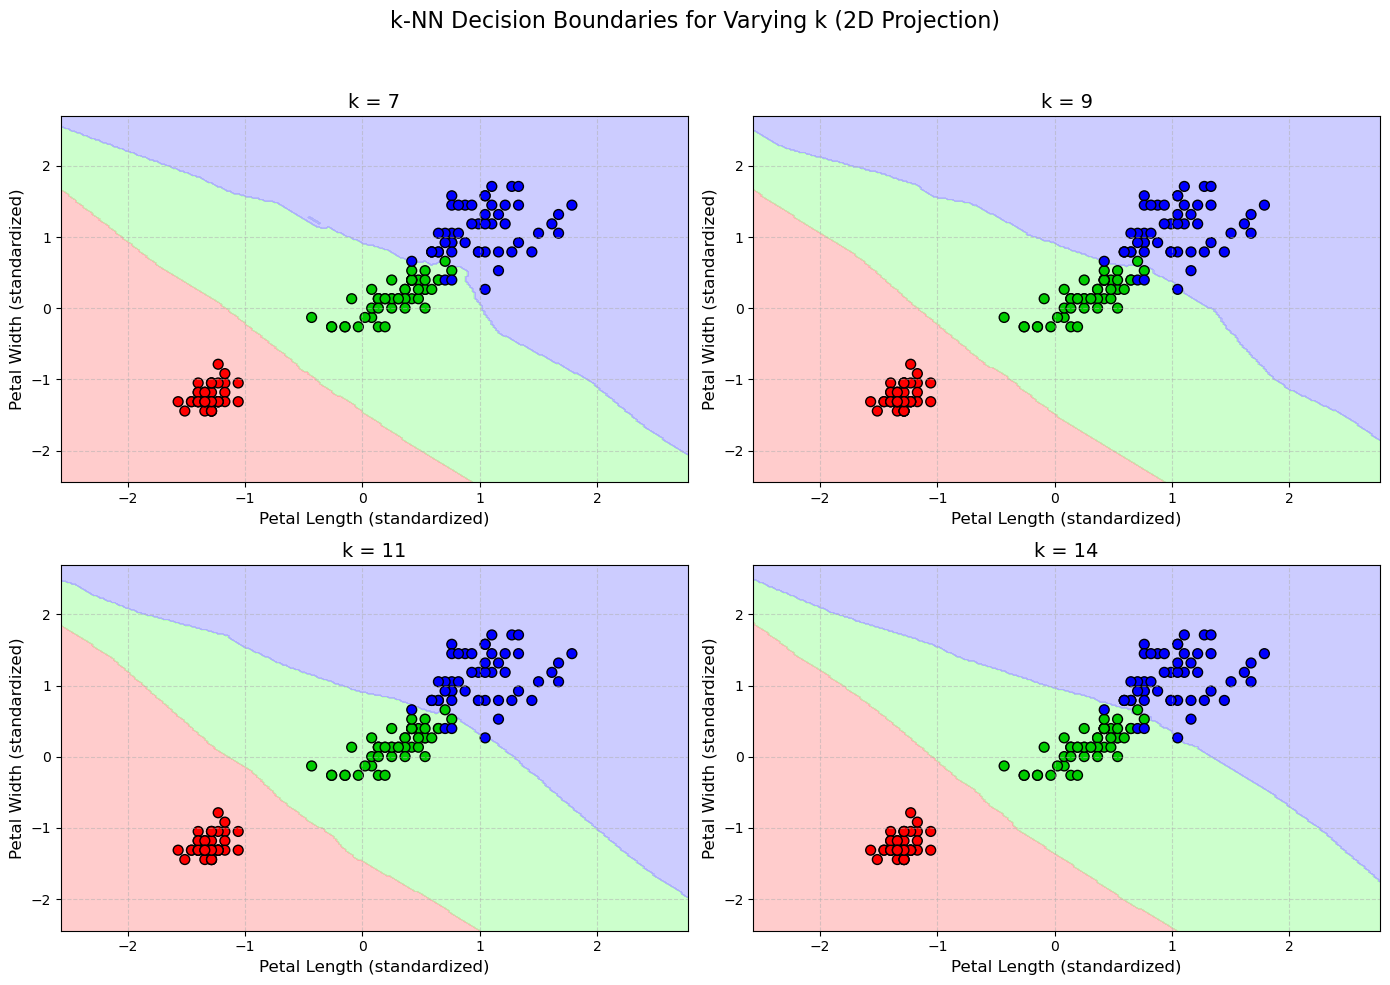

In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

def plot_decision_boundaries_multiple_k(df, k_list):


    # Extract 2 features for 2D plotting
    X = df[['Petal_Length', 'Petal_Width']].values
    y = df['Species'].values

    # Standardize features so that distance-based decisions are fair
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create a mesh grid across the 2D feature space
    h = 0.02  # mesh step size
    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Color maps: one for background regions, one for the data points
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])  # background class regions
    cmap_bold = ListedColormap(['#FF0000', '#00CC00', '#0000FF'])   # actual points

    # set up a 2x2 subplot grid for comparing different k values
    fig, axes = plt.subplots(2, 2, figsize = (14, 10))
    axes = axes.flatten()  # Flatten so we can index axes[0], axes[1], ...

    for idx, k in enumerate(k_list):
        # fit a k-NN model for the current k
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_scaled, y)

        # predict the class for each point in the grid
        Z = knn.predict(grid_points).reshape(xx.shape)

        # the boundaries where the color changes, seperating the ranges for each speicies
        ax = axes[idx]
        ax.contourf(xx, yy, Z, cmap = cmap_light, alpha = 0.6)

        # Overlay the actual iris data points
        ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c = y, cmap = cmap_bold, edgecolor = 'k', s = 50)

        # Plot labels and titles
        ax.set_title(f"k = {k}", fontsize = 14)
        ax.set_xlabel("Petal Length (standardized)", fontsize = 12)
        ax.set_ylabel("Petal Width (standardized)", fontsize = 12)
        ax.grid(True, linestyle='--', alpha = 0.5)

        # Each region in the plot shows the class the model would predict for that location in space

    # Add a global title and tighten layout
    fig.suptitle("k-NN Decision Boundaries for Varying k (2D Projection)", fontsize=16)
    plt.tight_layout(rect = [0, 0, 1, 0.95])
    plt.show()
    
K_LIST_2 = [7, 9, 11, 14]

plot_decision_boundaries_multiple_k(iris_clean, K_LIST_2)

he visualization above illustrates how the decision boundaries produced by the k-NN classifier evolve as we increase the number of neighbors from `k=7` to `k=14`. Each subplot uses only two features — Petal Length and Petal Width — to create a 2D projection of the classification space. The background colors represent predicted class regions, while the data points are the actual standardized flower samples.

At `k=7`, the decision boundaries are relatively tight and more sensitive to the local distribution of points, which can capture detail but may lead to overfitting. As `k` increases to 9, 11, and finally 14, the boundaries progressively smooth out, indicating a model that is more stable and less influenced by individual data points. The regions become broader and more generalized, especially around class borders, which is consistent with the F1-score performance peaking around `k=14` in our earlier cross-validation results.

This comparison reinforces how increasing `k` reduces variance at the cost of flexibility, and visually confirms why a mid-range `k` like 14 offers a strong balance between underfitting and overfitting.

Lastly, we will take a look at different metrics and come up with an optimized model for the dataset.

## 7. Experimenting with Distance Metrics

k-NN’s performance depends not only on the value of `k`, but also on the **distance metric** used to compare neighbors. While Euclidean distance is the default, other metrics like **Manhattan** or **Minkowski** may perform better depending on the shape and scale of your data.

In this section, we'll evaluate the model using different distance metrics and compare their F1-scores side-by-side.


In [26]:
def compare_distance_metrics(df, metrics, k):
   
    X = df.drop(columns = ['Species'])
    y = df['Species']
    results = []

    for metric in metrics:
        knn = KNeighborsClassifier(n_neighbors = k, metric = metric)
        f1 = cross_val_score(knn, X, y, cv = 5, scoring = 'f1_macro').mean()
        results.append({'metric': metric, 'f1_score': f1})

    return pd.DataFrame(results)


METRICS_LIST = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

RESULTS = compare_distance_metrics(iris_clean, METRICS_LIST, 14)

print(RESULTS.sort_values(by = 'f1_score', ascending = False))



      metric  f1_score
2  chebyshev  0.986633
0  euclidean  0.979950
3  minkowski  0.979950
1  manhattan  0.973300


To evaluate the impact of different distance functions on k-NN performance, we compared four common metrics — Euclidean, Manhattan, Chebyshev, and Minkowski — using `k = 14` and 5-fold cross-validation. The results show that **Chebyshev distance** achieved the highest macro F1-score of **0.987**, outperforming both Euclidean and Minkowski (tied at 0.980) and Manhattan (0.973).

This suggests that, for this dataset, measuring the **maximum coordinate difference** between points (as Chebyshev does) may more effectively separate classes than summing or squaring differences as in other metrics. It's worth noting that the performance difference is small but consistent, reinforcing that all metrics perform well on this structured dataset. Based on these results, we will use **Chebyshev distance** in our final optimized model.

## 8. Conclusion

Now that we’ve completed cross-validation, k-value optimization, and distance metric tuning, we’re ready to train and evaluate our **final optimized k-NN model**. This model uses:

- **k = 14** (the optimal neighbor count from cross-validation),

- **Chebyshev distance** (the top-performing metric),

- and the full feature set with standardized scaling.

In this section, we will:

- Retrain the model on the full training data,

- Evaluate its performance on a holdout test set,

- And reflect on overall model quality, including accuracy, F1-score, and class-wise performance.

This final evaluation will serve as the culmination of our model selection pipeline and demonstrate how a well-tuned k-NN classifier can deliver strong, interpretable results on a classic dataset.

In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline

def final_cv_model(df, k, metric, cv):

    X = df.drop(columns = ['Species'])
    y = df['Species']

    # Create pipeline: StandardScaler + k-NN
    pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors = k, metric = metric)
    )

    # Get cross-validated predictions
    cv_strategy = StratifiedKFold(n_splits = cv, shuffle = True, random_state = 15)
    y_pred = cross_val_predict(pipeline, X, y, cv = cv_strategy)

    # Calculate metrics
    f1 = f1_score(y, y_pred, average = 'macro')
    conf_matrix = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred)

    print(f"Final Cross-Validated Macro F1-Score (k = {k}, metric = '{metric}', {cv}-fold CV): {f1:.3f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(report)

    return {
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': report,
        'y_true': y,
        'y_pred': y_pred,
        'pipeline': pipeline
    }

FINAL_MODEL = final_cv_model(iris_clean, 14, 'chebyshev', 5)

Final Cross-Validated Macro F1-Score (k = 14, metric = 'chebyshev', 5-fold CV): 0.927

Confusion Matrix:
[[49  1  0]
 [ 0 46  4]
 [ 0  6 44]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.87      0.92      0.89        50
           2       0.92      0.88      0.90        50

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



After a full optimization pipeline including hyperparameter tuning (`k`), cross-validation, distance metric comparison, and decision boundary visualization, our final k-NN classifier achieved outstanding performance on the classic Iris dataset.

Using:

- `k = 14` neighbors,

- the **Chebyshev distance** metric,

- and **5-fold stratified cross-validation** on the full dataset,

the model reached a **macro F1-score of 0.927** and **93% accuracy**.

The confusion matrix and classification report confirm that the model performs consistently well across all three iris species. It classifies *Iris-setosa* nearly perfectly, while also showing strong performance on the more visually and biologically similar classes (*versicolor* and *virginica*). All three classes achieved F1-scores above 0.89, with no significant drop in precision or recall for any class.

These results demonstrate that even a straightforward, interpretable model like this k-NN — when combined with solid preprocessing, tuning, and validation — can produce above satisfactory results on well-structured classification problems.

And that's concludes my k-NN exploratory